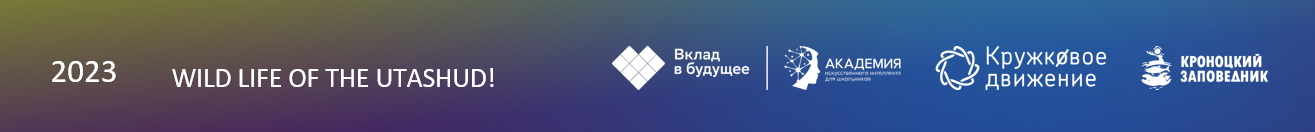

# Дикая жизнь Уташуда! Про чаечек.
# Wild life of the Utashud! About seagulls.

Привет, друг! Перед тобой бейзлайн хакатона "Дикая жизнь Уташуда", который проходит с 10 по 27 августа 2023 года. Этот бейзлайн позволит получить простое, но рабочее решение решение по посчету чаек с фотоловушек. Он позволяет получить тот результат, который можно загрузить на платформу провденеия соревнования и закрепить за собой место в рейтинге и право звания участника. Помни, что это самое простое решение, которе необходимо значительно дорабатывать.

Мы тут считаем количество чаек на фотографиях. Размер обнаруживаемых чаек должен быть равен или превышать 5х5 пикселей.

***

Hello, dear friend! This is the baseline code for the "Wild life of Utashud!" Hack, which runs from 08/10/2023 to 08/27/2023. This baseline will allow you to get a simple solution for seagulls count for images from camera traps. It allows you to get the result that can be uploaded to the competition platform and get a place in the leadearbord to become a  hack participant. Remember that this is the simplest solution that needs to be significantly improved.

We are counting the number of seagulls in the photographs. The size of the detected seagulls must be equal to or greater than 5x5 pixels.

С помощью git загружаем YOLOv5, переходим в папку с YOLO и устанавливаем зависимости.

***

Using git, download YOLOv5, go to the folder with YOLO and install dependencies.

In [ ]:
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
%pip install -qr requirements.txt

Cloning into 'yolov5'...
remote: Enumerating objects: 15897, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 15897 (delta 4), reused 16 (delta 4), pack-reused 15880
Receiving objects: 100% (15897/15897), 14.57 MiB | 16.82 MiB/s, done.
Resolving deltas: 100% (10903/10903), done.
/content/yolov5
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 616.7/616.7 kB 35.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.9 MB/s eta 0:00:00


Делаем так, что бы наши графики отображались корректно.

***

We make sure that our charts are displayed correctly.

In [ ]:
%matplotlib notebook
%matplotlib inline

Импортируем библиотеки, которые могут потребоваться.

***

We import required libraries.

In [ ]:
from glob import glob
import torch
import utils
import cv2
from sklearn.metrics import mean_squared_error as mse
from PIL import Image
import random
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
display = utils.notebook_init()

YOLOv5 🚀 v7.0-207-gdf48c20 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)


Setup complete ✅ (2 CPUs, 12.7 GB RAM, 24.5/78.2 GB disk)


# Загрузка датасета
# Dataset download


Загружаем и распаковываем датасет.

***

Downloading and unpacking the dataset.

In [ ]:
!wget https://zaborshicov.ru/hiden/dataset_seagulls.zip -O dataset.zip
!unzip dataset.zip

--2023-08-10 04:08:11--  https://zaborshicov.ru/hiden/dataset_seagulls.zip
Resolving zaborshicov.ru (zaborshicov.ru)... 46.8.141.165, 2a0b:6cc0::15
Connecting to zaborshicov.ru (zaborshicov.ru)|46.8.141.165|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 38431264 (37M) [application/zip]
Saving to: ‘dataset.zip’

dataset.zip         100%[===================>]  36.65M  2.47MB/s    in 17s     

2023-08-10 04:08:30 (2.14 MB/s) - ‘dataset.zip’ saved [38431264/38431264]

Archive:  dataset.zip
  inflating: data.yaml               
  inflating: train/images/20200520_194550_01_JPG.rf.595bdd5983267a4f1f44a85bb3534ff3.jpg  
  inflating: train/images/20200520_194644_01_JPG.rf.1e08abb4cab5aaf54d102fd3a7825a08.jpg  
  inflating: train/images/20200520_194755_01_JPG.rf.6b24d9bd15a052de6a14a242767fc17f.jpg  
  inflating: train/images/20200520_204821_01_JPG.rf.ee5c345169f48a0943a5aaa955e65ee5.jpg  
  inflating: train/images/20200521_055107_01_JPG.rf.38c155e81f3b8ee52059532662df

# Исследование данных
# Data exploration

Для начала посмотрим, какой средний размер у чаек и какое их количество на фотографиях в среднем.

***

To begin with, let's see what is the average size of seagulls and how many of them there are in the photos.

In [ ]:
pathes = glob('train/labels/*')
nums = []
size_width = []
size_height = []

for pth in pathes:
    with open(pth, 'r') as f:
        nums.append(0)
        for line in f:
            nums[-1] += 1
            width, height = map(float, line.split(' ')[-2:])
            size_width.append(width*960)
            size_height.append(height*640)

print(f'Среднее количество чаек на фото Avarage number of the seagulls: {sum(nums)/len(nums):.2f}')
print(f'Средний размер чайки Average size of the seagull: {sum(size_width)/len(size_width):.2f}x{sum(size_height)/len(size_height):.2f}')

Среднее количество чаек на фото: 10.77
Средний размер чайки: 27.77x25.13


Построим тепловую карту того, где чаще всего бывают чайки.

***

Let's build a heatmap of the most popular places among our seagulls.


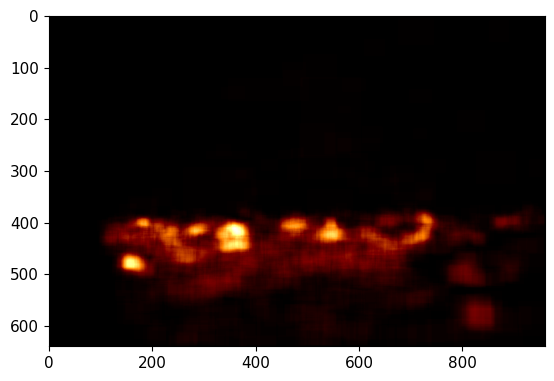

In [ ]:
heatmap = np.zeros((640, 960))
width = 960
height = 640
for pth in pathes:
    with open(pth, 'r') as f:
        for line in f:
            x, y, w, h = map(float, line.split(' ')[-4:])
            x_center = int(x * width)
            y_center = int(y * height)
            w = int(w * width)
            h = int(h * height)
            x1 = int(x_center - w / 2)
            y1 = int(y_center - h / 2)
            x2 = x1 + w
            y2 = y1 + h
            heatmap[y1:y2, x1:x2] += 1

plt.imshow(heatmap, cmap='afmhot')
plt.show()

Выведем пару фото.

***

Let`s have a look at the some photos.

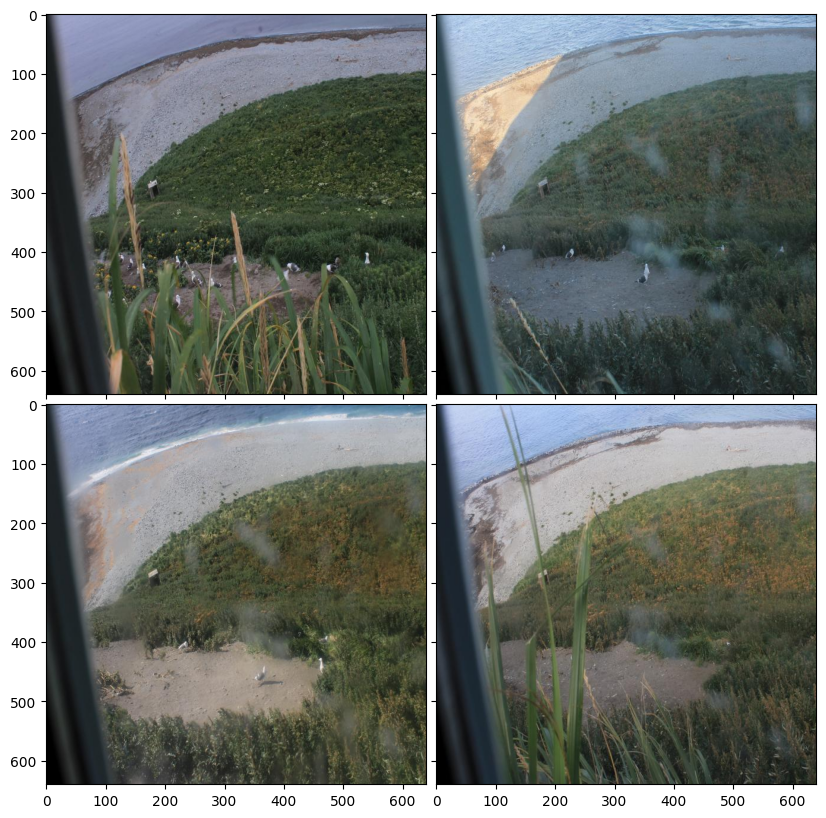

In [ ]:
fig = plt.figure(figsize=(10., 10.))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(2, 2),
                 axes_pad=0.1,
                 )

pathes = glob('/content/yolov5/train/images/*') #пути ко всем файлам в папке
images = [cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB) for img in random.choices(pathes, k = 4)] #выбираем 4 случайных фото и переводим их в RGB (OpenCV хранит фото в цветовом окружение BGR)

for ax, im in zip(grid, images):
    ax.imshow(im)

plt.show()

# Обучение
# Model training


Запускаем обучение нашей модели. Размер батча - **16**, количество эпох - **10**, размер фото - **320x320**. Файл **data.yaml** устанавливает пути до датасета, а также классы для детекции.

**yolov5n.pt** - веса, которые мы будем дообучать

**hyp.scratch-low.yaml** - гиперпараметры, которые устнанавливют как будет происходит обучение

***

Let's start model training. Batch size - **16**, number of epochs - **10**, photo size - **320x320**. The **data.yaml** file sets the paths to the dataset, as well as the detection classes.

**yolov5n.pt** - weights that we will retrain

**hyp.scratch-low.yaml** - hyperparameters that set how training will be done

In [ ]:
!python train.py --img 320 --batch 16 --epochs 10 --data data.yaml --weights yolov5n.pt --hyp data/hyps/hyp.scratch-low.yaml

WARNING ⚠️ 'ultralytics.yolo.v8' is deprecated since '8.0.136' and will be removed in '8.1.0'. Please use 'ultralytics.models.yolo' instead.
WARNING ⚠️ 'ultralytics.yolo.utils' is deprecated since '8.0.136' and will be removed in '8.1.0'. Please use 'ultralytics.utils' instead.
Note this warning may be related to loading older models. You can update your model to current structure with:
    import torch
    ckpt = torch.load("model.pt")  # applies to both official and custom models
    torch.save(ckpt, "updated-model.pt")

train: weights=yolov5n.pt, cfg=, data=data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=10, batch_size=16, imgsz=320, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], 

# Тестирование
# Model testing

Давайте поговорим про нашу метрику - RMSE. Но начнём мы с MSE. MSE - это одна из самых популярных метрик в задаче регрессии. MSE по сути является суммой квадратов разности между предсказанием и истинным значением. Формула MSE выглядит так:


\begin{equation}
MSE = \frac{Σ^N_{i=1}(y_i - pred_i)^2}{N}
\end{equation}

Формула RMSE по сути абсолютно такая же, за исключением того что мы добавляем в неё корень. Это надо для того чтобы мы смогли понять, на сколько в наших единицах измерения (в данном случае - количестве чаек) ошибатеся модель. Формула RMSE выглядит так:

\begin{equation}
RMSE = \sqrt{MSE} = \sqrt{\frac{Σ^N_{i=1}(y_i - pred_i)^2}{N}}
\end{equation}

***

Let's talk about our metric - RMSE. But let's start with MSE. MSE is one of the most popular regression metrics. The MSE is essentially the sum of the squares of the difference between the prediction and the true value. The MSE formula looks like this:


\begin{equation}
MSE = \frac{Σ^N_{i=1}(y_i - pred_i)^2}{N}
\end{equation}

The RMSE formula is essentially exactly the same, except that we add a root to it. This is necessary so that we can understand how much the model is wrong in our units of measurement (in this case, the number of gulls). The RMSE formula looks like this:

\begin{equation}
RMSE = \sqrt{MSE} = \sqrt{\frac{Σ^N_{i=1}(y_i - pred_i)^2}{N}}
\end{equation}


Тестируем наш результат с помощью встроенной утилиты и выводим результат работы сети на одном из изображений.


**last.pt** - веса после последней эпохи обучения, **best.pt** - веса показавшие лучший результат на тестовой выборке


Флаги detect.py:
- img - размер, в который мы ресайзим картинку. Это необходимо, что бы модель получила на вход неообходимое ей количество пикселей. Не больше и не меньше.
- conf - порог "уверенности" после которого мы считаем предсказаение сети верными. В бейзлайне это 25%
- sourse - папка, на базе которой будет проходить тестирование
- img - размер фото, которое идёт на вход нейронной сети

***

We test our result using the built-in utility and display the result of the network on one of the images.


**last.pt** - weights after the last training epoch, **best.pt** - weights that showed the best result on the test set


detect.py flags:
- img - the size in which we resize the image. This is necessary so that the model receives the required number of pixels as input. No more and no less.
- conf - "confidence" threshold after which we consider the network's prediction to be correct. In baseline it's 25%
- source - folder on the basis of which testing will be carried out
- img - the size of the photo that goes to the input of the neural network

In [ ]:
!python detect.py --weights /content/yolov5/runs/train/exp/weights/last.pt --img 320 --conf 0.25 --source valid/images

WARNING ⚠️ 'ultralytics.yolo.v8' is deprecated since '8.0.136' and will be removed in '8.1.0'. Please use 'ultralytics.models.yolo' instead.
WARNING ⚠️ 'ultralytics.yolo.utils' is deprecated since '8.0.136' and will be removed in '8.1.0'. Please use 'ultralytics.utils' instead.
Note this warning may be related to loading older models. You can update your model to current structure with:
    import torch
    ckpt = torch.load("model.pt")  # applies to both official and custom models
    torch.save(ckpt, "updated-model.pt")

detect: weights=['/content/yolov5/runs/train/exp/weights/last.pt'], source=valid/images, data=data/coco128.yaml, imgsz=[320, 320], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, 

Визуализируем результат для того что бы понять, на сколько хорошо арботет наша модель.

***

We visualize the result in order to understand how good our model is.

In [ ]:
fig = plt.figure(figsize=(10., 10.))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(2, 2),
                 axes_pad=0.1,
                 )

pathes = glob('/content/yolov5/runs/detect/exp/*')
images = [cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB) for img in random.choices(pathes, k = 4)]

for ax, im in zip(grid, images):
    ax.imshow(im)

plt.show()

Рассчитываем RMSE

***

Calculate RMSE

In [ ]:
model = torch.hub.load('ultralytics/yolov5', 'custom', path='/content/yolov5/runs/train/exp/weights/last.pt', force_reload=True)
model.conf = 0.25 #нижняя планка вероятности для предсказания
preds = []
y = []

for pth in glob(r'valid/images/*'):
    img = Image.open(pth)
    results = model(img)
    preds.append(results.xyxy[0].shape[0]) #количество обнаруженых чаек
    f = open(pth.replace('images', 'labels')[:-3] + 'txt', 'r')
    y.append(len(list(f)))
    f.close()


print(f'RMSE = {mse(y, preds, squared=False)**0.5}')

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 v7.0-193-g485da42 Python-3.10.6 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 157 layers, 1760518 parameters, 0 gradients, 4.1 GFLOPs
Adding AutoShape... 


RMSE = 1.9339874195461564


## Сохранение предсказаний
## Save our predictions

In [ ]:
import pandas as pd

paths = []
preds = []
for pth in glob('test/*'):
    img = Image.open(pth)
    results = model(img)
    preds.append(results.xyxy[0].shape[0])
    paths.append(pth.split('/')[-1])

df = pd.DataFrame(list(zip(paths, preds)), columns=['filename', 'num'])
df.to_csv('count.csv', index=False)

Варианты улучшения результатов:
1. Изменение гипермараметров, весов или датасета (аугментации и другие методы)
2. Изменение количества эпох
3. Постобработка результатов (отсеивание коробок, не удовлетворящих требованиям)
4. Использования других версий модели или других моделей
5. Всяческие манипуляции с картинкой

***

Options for results improvement:
1. Changing hyperparameters, weights or dataset (augmentation and other methods)
2. Changing the number of epochs
3. Post-processing of results (screening out boxes that do not meet the requirements)
4. Use of other versions of the model or other models
5. All kinds of manipulations with the pictures